# Ass11 - Enhancements + other refinements 

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import yfinance as yf

plt.style.use("default")

ANNUAL_DAYS = 252
H_MONTH = 1
H = H_MONTH / 12.0
ROLL_WIN_6M = 126
MA_WIN = 5

DV01_BUDGET_TOTAL = 100_000
DV01_LIMIT_FLY = 0.25 * DV01_BUDGET_TOTAL
CAPITAL_PER_DV01 = 100.0
MAX_FLY_POSITIONS = 4

ENTRY_Z = 1.6
EXIT_Z = 0.2

xlsx_path = Path("Yield curve arb.xlsx")


## Load and clean sovereign yield curves, then build per-country curve panels

In [ ]:
yc_cols = [
    "Date", "USG2YR",
    "Date.1", "USG5YR",
    "Date.2", "US10GYR",
    "Date.3", "US30GYR",
    "Date.4", "GDBR2",
    "Date.5", "GDBR5",
    "Date.6", "GDBR10",
    "Date.7", "GDBR30",
    "Date.8", "GUKG2",
    "Date.9", "GUKG5",
    "Date.10", "GUKG10",
    "Date.11", "GUKG30",
    "Date.12", "GBTPGR2",
    "Date.13", "GBTPGR5",
    "Date.14", "GBTPGR10",
    "Date.15", "GBTPGR30",
    "Date.16", "JGBS2",
    "Date.17", "JGBS5",
    "Date.18", "JGBS10",
    "Date.19", "JGBS30",
    "Date.20", "GTAUD2Y",
    "Date.21", "GTAUD5Y",
    "Date.22", "GTAUD10Y",
    "Date.23", "GTAUD30Y",
    "Date.24", "GTCAD2Y",
    "Date.25", "GTCAD5Y",
    "Date.26", "GTCAD10Y",
    "Date.27", "GTCAD30Y",
]

raw_yc = pd.read_excel(xlsx_path, sheet_name="Yield Signals")
raw_yc = raw_yc[yc_cols]

yc_series_list = []

for date_col, yld_col in zip(yc_cols[0::2], yc_cols[1::2]):
    series_name = yld_col
    df_i = raw_yc[[date_col, yld_col]].copy()
    df_i.columns = ["Date", series_name]
    df_i = df_i.dropna(how="all")
    df_i["Date"] = pd.to_datetime(df_i["Date"], errors="coerce")
    df_i = df_i.dropna(subset=["Date"])
    df_i = df_i.set_index("Date").sort_index()
    df_i = df_i[~df_i.index.duplicated(keep="last")]
    yc_series_list.append(df_i)

yields = pd.concat(yc_series_list, axis=1).sort_index()
yields = yields / 100.0
yields = yields.ffill()

print("Yields panel shape:", yields.shape)
display(yields.head())

CURVE_COLS = {
    "US": ["USG2YR", "USG5YR", "US10GYR", "US30GYR"],
    "DE": ["GDBR2", "GDBR5", "GDBR10", "GDBR30"],
    "UK": ["GUKG2", "GUKG5", "GUKG10", "GUKG30"],
    "IT": ["GBTPGR2", "GBTPGR5", "GBTPGR10", "GBTPGR30"],
    "JP": ["JGBS2", "JGBS5", "JGBS10", "JGBS30"],
    "AU": ["GTAUD2Y", "GTAUD5Y", "GTAUD10Y", "GTAUD30Y"],
    "CA": ["GTCAD2Y", "GTCAD5Y", "GTCAD10Y", "GTCAD30Y"],
}

TENOR_MAP = {
    "USG2YR": 2.0, "USG5YR": 5.0, "US10GYR": 10.0, "US30GYR": 30.0,
    "GDBR2": 2.0, "GDBR5": 5.0, "GDBR10": 10.0, "GDBR30": 30.0,
    "GUKG2": 2.0, "GUKG5": 5.0, "GUKG10": 10.0, "GUKG30": 30.0,
    "GBTPGR2": 2.0, "GBTPGR5": 5.0, "GBTPGR10": 10.0, "GBTPGR30": 30.0,
    "JGBS2": 2.0, "JGBS5": 5.0, "JGBS10": 10.0, "JGBS30": 30.0,
    "GTAUD2Y": 2.0, "GTAUD5Y": 5.0, "GTAUD10Y": 10.0, "GTAUD30Y": 30.0,
    "GTCAD2Y": 2.0, "GTCAD5Y": 5.0, "GTCAD10Y": 10.0, "GTCAD30Y": 30.0,
}

def build_curve_df_for_country(yields_df: pd.DataFrame, country: str) -> pd.DataFrame:
    cols = CURVE_COLS[country]
    sub = yields_df[cols].copy()
    tenors = [TENOR_MAP[c] for c in cols]
    sub.columns = tenors
    sub = sub[sorted(sub.columns)]
    return sub

curve_by_cty = {
    country: build_curve_df_for_country(yields, country)
    for country in CURVE_COLS.keys()
}

curve_by_cty["US"].head()


Yields panel shape: (5413, 28)


,USG2YR,USG5YR,US10GYR,US30GYR,GDBR2,GDBR5,GDBR10,GDBR30,GUKG2,GUKG5,...,JGBS10,JGBS30,GTAUD2Y,GTAUD5Y,GTAUD10Y,GTAUD30Y,GTCAD2Y,GTCAD5Y,GTCAD10Y,GTCAD30Y
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,0.030896,0.036214,0.042104,0.048121,0.02470,0.02997,0.03639,0.04241,0.04440,0.04497,...,NaN,NaN,0.05043,0.05200,0.05329,NaN,0.02999,0.03683,0.04307,0.04841
2005-01-04,0.031962,0.037090,0.042886,0.048856,0.02491,0.03028,0.03653,0.04253,0.04429,0.04478,...,0.01404,0.02394,0.05166,0.05332,0.05463,NaN,0.03050,0.03719,0.04340,0.04864
2005-01-05,0.032046,0.037161,0.042808,0.048472,0.02484,0.03022,0.03654,0.04243,0.04439,0.04483,...,0.01405,0.02392,0.05183,0.05357,0.05482,NaN,0.03040,0.03696,0.04319,0.04847
2005-01-06,0.031556,0.036811,0.042612,0.048451,0.02441,0.02980,0.03625,0.04213,0.04419,0.04458,...,0.01405,0.02389,0.05152,0.05323,0.05454,NaN,0.03014,0.03681,0.04309,0.04839
2005-01-07,0.031891,0.037130,0.042690,0.048350,0.02439,0.02970,0.03610,0.04185,0.04425,0.04458,...,0.01404,0.02395,0.05104,0.05273,0.05402,NaN,0.03092,0.03753,0.04356,0.04862


## Now we look at futures, then align all of them to common dates

In [ ]:
fut_cols = [
    "Date", "TU1 Comdty",
    "Date.1", "FV1 Comdty",
    "Date.2", "TY1 Comdty",
    "Date.3", "US1 Comdty",
    "Date.4", "DU1 Comdty",
    "Date.5", "OE1 Comdty",
    "Date.6", "RX1 Comdty",
    "Date.7", "UB1 Comdty",
    "Date.8", "WB1 Comdty",
    "Date.9", "WX1 Comdty",
    "Date.10", "G 1 Comdty",
    "Date.11", "UGL1 Comdty",
]

raw_fut = pd.read_excel(xlsx_path, sheet_name="Futs")
raw_fut = raw_fut[fut_cols]

fut_series_list = []

for date_col, px_col in zip(fut_cols[0::2], fut_cols[1::2]):
    series_name = px_col
    df_i = raw_fut[[date_col, px_col]].copy()
    df_i.columns = ["Date", series_name]
    df_i = df_i.dropna(how="all")
    df_i["Date"] = pd.to_datetime(df_i["Date"], dayfirst=True, errors="coerce")
    df_i = df_i.dropna(subset=["Date"])
    df_i = df_i.set_index("Date").sort_index()
    df_i = df_i[~df_i.index.duplicated(keep="last")]
    fut_series_list.append(df_i)

futures_px = pd.concat(fut_series_list, axis=1).sort_index()
futures_px = futures_px.ffill()

print("Futures panel shape:", futures_px.shape)
display(futures_px.head())

common_dates = None
for cty, cdf in curve_by_cty.items():
    common_dates = cdf.index if common_dates is None else common_dates.intersection(cdf.index)
common_dates = common_dates.intersection(futures_px.index)
common_dates = common_dates.sort_values()

for cty in curve_by_cty.keys():
    curve_by_cty[cty] = curve_by_cty[cty].reindex(common_dates).ffill()

futures_px = futures_px.reindex(common_dates).ffill()

print("Common date range:", common_dates.min(), "→", common_dates.max())
print("Number of common dates:", len(common_dates))


Futures panel shape: (5365, 12)


,TU1 Comdty,FV1 Comdty,TY1 Comdty,US1 Comdty,DU1 Comdty,OE1 Comdty,RX1 Comdty,UB1 Comdty,WB1 Comdty,WX1 Comdty,G 1 Comdty,UGL1 Comdty
Date,,,,,,,,,,,,
2005-01-03,104.750000,109.437500,111.875000,112.53125,106.065,113.04,118.94,95.83,NaN,NaN,NaN,NaN
2005-01-04,104.562500,109.062500,111.406250,111.78125,106.015,112.88,118.85,95.63,NaN,NaN,111.63,NaN
2005-01-05,104.546875,109.031250,111.406250,112.06250,106.050,112.97,118.90,95.81,NaN,NaN,111.47,NaN
2005-01-06,104.609375,109.109375,111.484375,112.09375,106.115,113.10,119.03,95.81,NaN,NaN,111.72,NaN
2005-01-07,104.546875,108.984375,111.375000,112.09375,106.105,113.16,119.19,95.81,NaN,NaN,111.77,NaN


# build yield curves + tenors

In [ ]:

CURVE_COLS = {
    "US": ["USG2YR","USG5YR","US10GYR","US30GYR"],
    "DE": ["GDBR2","GDBR5","GDBR10","GDBR30"],
    "UK": ["GUKG2","GUKG5","GUKG10","GUKG30"],
    "IT": ["GBTPGR2","GBTPGR5","GBTPGR10","GBTPGR30"],
    "JP": ["JGBS2","JGBS5","JGBS10","JGBS30"],
    "AU": ["GTAUD2Y","GTAUD5Y","GTAUD10Y","GTAUD30Y"],
    "CA": ["GTCAD2Y","GTCAD5Y","GTCAD10Y","GTCAD30Y"],
}

TENOR_MAP = {
    "USG2YR":2.0,"USG5YR":5.0,"US10GYR":10.0,"US30GYR":30.0,
    "GDBR2":2.0,"GDBR5":5.0,"GDBR10":10.0,"GDBR30":30.0,
    "GUKG2":2.0,"GUKG5":5.0,"GUKG10":10.0,"GUKG30":30.0,
    "GBTPGR2":2.0,"GBTPGR5":5.0,"GBTPGR10":10.0,"GBTPGR30":30.0,
    "JGBS2":2.0,"JGBS5":5.0,"JGBS10":10.0,"JGBS30":30.0,
    "GTAUD2Y":2.0,"GTAUD5Y":5.0,"GTAUD10Y":10.0,"GTAUD30Y":30.0,
    "GTCAD2Y":2.0,"GTCAD5Y":5.0,"GTCAD10Y":10.0,"GTCAD30Y":30.0,
}

def build_curve_df_for_country(yields_df: pd.DataFrame, country: str) -> pd.DataFrame:
    cols = CURVE_COLS[country]
    sub = yields_df[cols].copy()
    tenors = [TENOR_MAP[c] for c in cols]
    sub.columns = tenors
    # Ensure sorted by tenor: 2,5,10,30 (whatever else we have)
    sub = sub[sorted(sub.columns)]
    return sub

curve_by_cty = {
    country: build_curve_df_for_country(yields, country)
    for country in CURVE_COLS.keys()
}

curve_by_cty["US"].head()

,2.0,5.0,10.0,30.0
Date,,,,
2005-01-03,0.030896,0.036214,0.042104,0.048121
2005-01-04,0.031962,0.037090,0.042886,0.048856
2005-01-05,0.032046,0.037161,0.042808,0.048472
2005-01-06,0.031556,0.036811,0.042612,0.048451
2005-01-07,0.031891,0.037130,0.042690,0.048350


## Curve interplation,CRD, and fly signal generation (govt curves) with example plot

Number of (country, fly) signal series: 14
[('US', '2s5s10s'), ('US', '5s10s30s'), ('DE', '2s5s10s'), ('DE', '5s10s30s'), ('UK', '2s5s10s'), ('UK', '5s10s30s'), ('IT', '2s5s10s'), ('IT', '5s10s30s'), ('JP', '2s5s10s'), ('JP', '5s10s30s')]


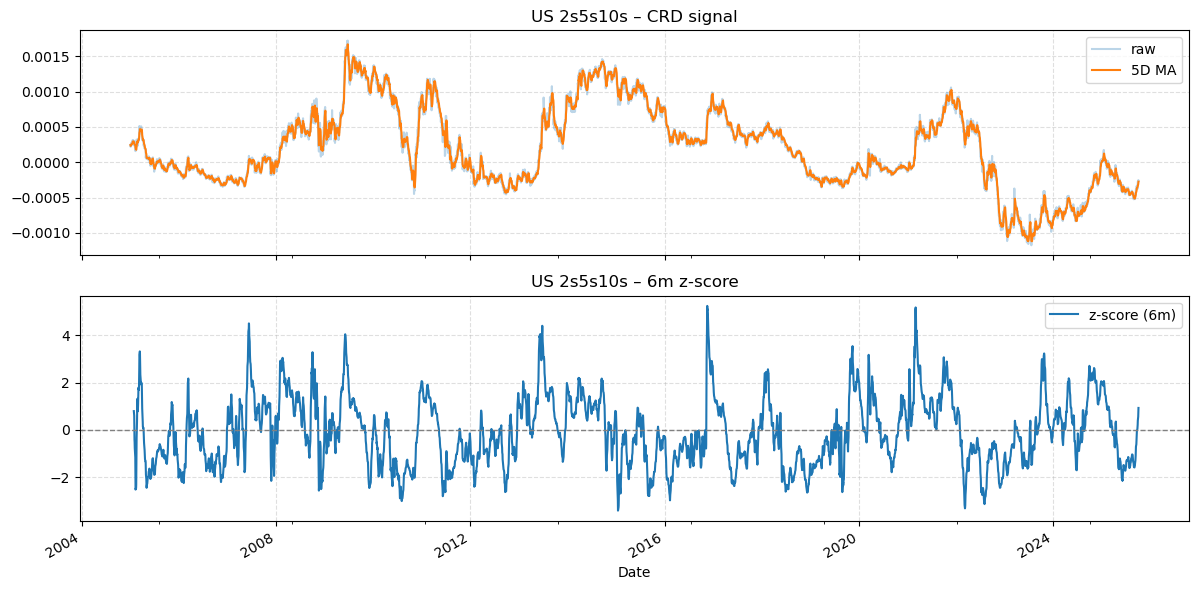

In [108]:
def zero_coupon(y: float, T: float):
    P = np.exp(-y * T)
    dv01 = P * T * 1e-4
    return P, dv01

def interp_yield(curve_row: pd.Series, T: float) -> float:
    xs = curve_row.index.values.astype(float)
    ys = curve_row.values.astype(float)
    order = np.argsort(xs)
    xs, ys = xs[order], ys[order]
    return float(np.interp(T, xs, ys))

def roll_down_dy(curve_row: pd.Series, T: float, H: float) -> float:
    if T - H <= 0:
        return 0.0
    y_T = interp_yield(curve_row, T)
    y_TH = interp_yield(curve_row, T - H)
    return y_TH - y_T

def crd_single_leg(curve_row: pd.Series, T: float, H: float, fund_rate: float):
    y = interp_yield(curve_row, T)
    P, dv01 = zero_coupon(y, T)
    dy_roll = roll_down_dy(curve_row, T, H)
    dy_bps = dy_roll * 1e4
    roll_pnl = -dv01 * dy_bps
    carry = (y - fund_rate) * H * P
    crd_ret = (roll_pnl + carry) / P
    return crd_ret, P, dv01

def fly_weight_DV01_neutral(dv01_L, dv01_B, dv01_R):
    A = np.array([[dv01_L, dv01_R],
                  [1.0, 1.0]])
    b = np.array([-dv01_B, -1.0])
    w_L, w_R = np.linalg.solve(A, b)
    return float(w_L), 1.0, float(w_R)

def compute_signal_for_fly(curve_df: pd.DataFrame,
                           tenors: tuple,
                           H: float,
                           roll_win: int = ROLL_WIN_6M,
                           ma_win: int = MA_WIN) -> pd.DataFrame:
    T_L, T_B, T_R = tenors
    rows = []

    for date, curve_row in curve_df.iterrows():
        if curve_row.isna().any():
            rows.append((date, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan))
            continue

        if 2.0 in curve_row.index:
            fund_rate = curve_row.loc[2.0]
        else:
            fund_rate = curve_row.iloc[0]

        crd_L, P_L, dv01_L = crd_single_leg(curve_row, T_L, H, fund_rate)
        crd_B, P_B, dv01_B = crd_single_leg(curve_row, T_B, H, fund_rate)
        crd_R, P_R, dv01_R = crd_single_leg(curve_row, T_R, H, fund_rate)

        wL, wB, wR = fly_weight_DV01_neutral(dv01_L, dv01_B, dv01_R)
        fly_dv01 = dv01_L * wL + dv01_B * wB + dv01_R * wR

        fly_dv01_abs = (
            abs(dv01_L * wL) +
            abs(dv01_B * wB) +
            abs(dv01_R * wR)
        )

        fly_crd = wL * crd_L + wB * crd_B + wR * crd_R

        rows.append((date, fly_crd, wL, wB, wR, fly_dv01, fly_dv01_abs, fund_rate))

    sig_df = pd.DataFrame(
        rows,
        columns=[
            "Date",
            "sig_raw",
            "wL", "wB", "wR",
            "fly_dv01",
            "fly_dv01_abs",
            "fund_rate",
        ],
    ).set_index("Date")

    sig_df["sig_smooth"] = sig_df["sig_raw"].rolling(ma_win, min_periods=1).mean()
    roll = sig_df["sig_smooth"].rolling(roll_win, min_periods=20)
    sig_df["z_sig_6m"] = (sig_df["sig_smooth"] - roll.mean()) / roll.std(ddof=1)

    return sig_df

FLIES = [
    (2.0, 5.0, 10.0),
    (5.0, 10.0, 30.0),
]

sig_by_key = {}

for country, curve_df in curve_by_cty.items():
    for tenors in FLIES:
        if not all(t in curve_df.columns for t in tenors):
            continue
        fly_name = f"{int(tenors[0])}s{int(tenors[1])}s{int(tenors[2])}s"
        sig_df = compute_signal_for_fly(curve_df, tenors, H)
        key = (country, fly_name)
        sig_by_key[key] = {
            "tenors": tenors,
            "sig_df": sig_df,
        }

print("Number of (country, fly) signal series:", len(sig_by_key))
print(list(sig_by_key.keys())[:10])

example_key = ("US", "2s5s10s")
example_sig = sig_by_key[example_key]["sig_df"]

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

example_sig["sig_raw"].plot(ax=ax[0], alpha=0.3, label="raw")
example_sig["sig_smooth"].plot(ax=ax[0], label="5D MA")
ax[0].set_title("US 2s5s10s – CRD signal")
ax[0].legend()
ax[0].grid(True, linestyle="--", alpha=0.4)

example_sig["z_sig_6m"].plot(ax=ax[1], label="z-score (6m)")
ax[1].axhline(0, linestyle="--", linewidth=1, color="grey")
ax[1].set_title("US 2s5s10s – 6m z-score")
ax[1].legend()
ax[1].grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


## Load and clean IRS curves, mapping to specific countires and then building the IRS fly fingals

In [109]:
irs_cols = [
    "Date", "USSW2",
    "Date.1", "USSW5",
    "Date.2", "USSW10",
    "Date.3", "USSW30",
    "Date.4", "EUSA2",
    "Date.5", "EUSA5",
    "Date.6", "EUSA10",
    "Date.7", "EUSA30",
    "Date.8", "BPSW2",
    "Date.9", "BPSW5",
    "Date.10", "BPSW10",
    "Date.11", "BPSW30",
    "Date.12", "JYSW2",
    "Date.13", "JYSW5",
    "Date.14", "JYSW10",
    "Date.15", "JYSW30",
    "Date.16", "CDSW2",
    "Date.17", "CDSW5",
    "Date.18", "CDSW10",
    "Date.19", "CDSW30",
    "Date.20", "ADSW2",
    "Date.21", "ADSW5",
    "Date.22", "ADSW10",
    "Date.23", "ADSW30",
]

raw_irs = pd.read_excel(xlsx_path, sheet_name="IRS")
raw_irs = raw_irs[irs_cols]

irs_series_list = []

for date_col, yld_col in zip(irs_cols[0::2], irs_cols[1::2]):
    series_name = yld_col
    df_i = raw_irs[[date_col, yld_col]].copy()
    df_i.columns = ["Date", series_name]
    df_i = df_i.dropna(how="all")
    df_i["Date"] = pd.to_datetime(df_i["Date"], dayfirst=True, errors="coerce")
    df_i = df_i.dropna(subset=["Date"])
    df_i = df_i.set_index("Date").sort_index()
    df_i = df_i[~df_i.index.duplicated(keep="last")]
    irs_series_list.append(df_i)

irs = pd.concat(irs_series_list, axis=1).sort_index()
irs = irs / 100.0
irs = irs.ffill()

print("IRS panel shape:", irs.shape)
display(irs.head())

IRS_CURVE_COLS = {
    "US": ["USSW2", "USSW5", "USSW10", "USSW30"],
    "DE": ["EUSA2", "EUSA5", "EUSA10", "EUSA30"],
    "UK": ["BPSW2", "BPSW5", "BPSW10", "BPSW30"],
    "JP": ["JYSW2", "JYSW5", "JYSW10", "JYSW30"],
    "CA": ["CDSW2", "CDSW5", "CDSW10", "CDSW30"],
    "AU": ["ADSW2", "ADSW5", "ADSW10", "ADSW30"],
}

IRS_TENOR_MAP = {
    "USSW2": 2.0, "USSW5": 5.0, "USSW10": 10.0, "USSW30": 30.0,
    "EUSA2": 2.0, "EUSA5": 5.0, "EUSA10": 10.0, "EUSA30": 30.0,
    "BPSW2": 2.0, "BPSW5": 5.0, "BPSW10": 10.0, "BPSW30": 30.0,
    "JYSW2": 2.0, "JYSW5": 5.0, "JYSW10": 10.0, "JYSW30": 30.0,
    "CDSW2": 2.0, "CDSW5": 5.0, "CDSW10": 10.0, "CDSW30": 30.0,
    "ADSW2": 2.0, "ADSW5": 5.0, "ADSW10": 10.0, "ADSW30": 30.0,
}

def build_irs_curve_for_country(irs_df: pd.DataFrame, country: str) -> pd.DataFrame:
    cols = IRS_CURVE_COLS[country]
    sub = irs_df[cols].copy()
    tenors = [IRS_TENOR_MAP[c] for c in cols]
    sub.columns = tenors
    sub = sub[sorted(sub.columns)]
    return sub

irs_curve_by_cty = {
    cty: build_irs_curve_for_country(irs, cty)
    for cty in IRS_CURVE_COLS.keys()
}

irs_curve_by_cty["US"].head()

common_dates = None

for cty, cdf in curve_by_cty.items():
    common_dates = cdf.index if common_dates is None else common_dates.intersection(cdf.index)

common_dates = common_dates.intersection(futures_px.index)

for cty, cdf in irs_curve_by_cty.items():
    common_dates = common_dates.intersection(cdf.index)

common_dates = common_dates.sort_values()

for cty in curve_by_cty.keys():
    curve_by_cty[cty] = curve_by_cty[cty].reindex(common_dates).ffill()

for cty in irs_curve_by_cty.keys():
    irs_curve_by_cty[cty] = irs_curve_by_cty[cty].reindex(common_dates).ffill()

futures_px = futures_px.reindex(common_dates).ffill()

print("Common date range (all data):", common_dates.min(), "→", common_dates.max())
print("Number of common dates:", len(common_dates))

FLIES = [
    (2.0, 5.0, 10.0),
    (5.0, 10.0, 30.0),
]

sig_by_key_irs = {}

for country, curve_df in irs_curve_by_cty.items():
    for tenors in FLIES:
        if not all(t in curve_df.columns for t in tenors):
            continue
        fly_name = f"{int(tenors[0])}s{int(tenors[1])}s{int(tenors[2])}s"
        sig_df_irs = compute_signal_for_fly(curve_df, tenors, H)
        key = (country, fly_name)
        sig_by_key_irs[key] = {
            "tenors": tenors,
            "sig_df": sig_df_irs,
        }

print("Number of (country, fly) IRS signal series:", len(sig_by_key_irs))
print("Example IRS keys:", list(sig_by_key_irs.keys())[:5])


IRS panel shape: (5413, 24)


,USSW2,USSW5,USSW10,USSW30,EUSA2,EUSA5,EUSA10,EUSA30,BPSW2,BPSW5,...,JYSW10,JYSW30,CDSW2,CDSW5,CDSW10,CDSW30,ADSW2,ADSW5,ADSW10,ADSW30
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,0.026115,0.031260,0.03715,0.043135,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.056650,0.057965,0.057775
2005-01-04,NaN,NaN,NaN,NaN,0.026345,0.031540,0.03723,0.043167,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.055900,0.058275,0.059725,0.059600
2005-01-05,NaN,NaN,NaN,NaN,0.026210,0.031405,0.03717,0.043140,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.056290,0.058100,0.059400,0.059275
2005-01-06,NaN,NaN,NaN,NaN,0.025845,0.031165,0.03709,0.042970,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.055990,0.057700,0.058885,0.058825
2005-01-07,NaN,NaN,NaN,NaN,0.025815,0.031090,0.03693,0.042795,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.055705,0.057480,0.058400,0.058550


Common date range (all data): 2005-01-03 00:00:00 → 2025-10-01 00:00:00
Number of common dates: 5365
Number of (country, fly) IRS signal series: 12
Example IRS keys: [('US', '2s5s10s'), ('US', '5s10s30s'), ('DE', '2s5s10s'), ('DE', '5s10s30s'), ('UK', '2s5s10s')]


# Combine the gov and IRS signals usign a agreemnt filter to build filtered z-scores. IRS only from 2008 onwards, do note.

In [110]:
for key, gov_obj in sig_by_key.items():
    country, fly_name = key
    gov_sig = gov_obj["sig_df"]

    if key not in sig_by_key_irs:
        gov_sig["z_sig_6m_irs"] = np.nan
        gov_sig["filter_ok"] = True
        gov_sig["z_sig_6m_filtered"] = gov_sig["z_sig_6m"]
        sig_by_key[key]["sig_df"] = gov_sig
        continue

    irs_sig = sig_by_key_irs[key]["sig_df"]
    irs_sig_aligned = irs_sig.reindex(gov_sig.index)
    gov_sig["z_sig_6m_irs"] = irs_sig_aligned["z_sig_6m"]

    z_gov = gov_sig["z_sig_6m"]
    z_irs = gov_sig["z_sig_6m_irs"]

    irs_missing = z_irs.isna()
    same_sign = np.sign(z_gov) * np.sign(z_irs) > 0
    both_valid = z_gov.notna() & z_irs.notna()
    sign_agree = same_sign & both_valid

    filter_ok = (irs_missing & z_gov.notna()) | sign_agree

    gov_sig["filter_ok"] = filter_ok
    gov_sig["z_sig_6m_filtered"] = np.where(filter_ok, z_gov, np.nan)

    sig_by_key[key]["sig_df"] = gov_sig

example_key = ("US", "2s5s10s")
if example_key in sig_by_key:
    display(
        sig_by_key[example_key]["sig_df"]
        [["z_sig_6m", "z_sig_6m_irs", "filter_ok", "z_sig_6m_filtered"]]
        .loc["2005":"2012"]
        .head(20)
    )


,z_sig_6m,z_sig_6m_irs,filter_ok,z_sig_6m_filtered
Date,,,,
2005-01-03,NaN,NaN,False,NaN
2005-01-04,NaN,NaN,False,NaN
2005-01-05,NaN,NaN,False,NaN
2005-01-06,NaN,NaN,False,NaN
2005-01-07,NaN,NaN,False,NaN
2005-01-10,NaN,NaN,False,NaN
2005-01-11,NaN,NaN,False,NaN
2005-01-12,NaN,NaN,False,NaN
2005-01-13,NaN,NaN,False,NaN


## Defining the  transaction-cost settings, futures mapping, and the main cost-aware portfolio backtest

In [111]:
COST_ROUNDTRIP_BP_COUNTRY = {
    "US": 0.12,
    "DE": 0.12,
    "UK": 0.18,
    "JP": 0.08,
    "AU": 0.35,
    "CA": 0.25,
    "IT": 0.50,
}

FLY_LIQ_MULT = {
    "2s5s10s": 1.0,
    "5s10s30s": 1.3,
}

def zero_price_from_curve(curve_row: pd.Series, T: float) -> float:
    y = interp_yield(curve_row, T)
    P, _ = zero_coupon(y, T)
    return P

FUT_MAP = {
    "US": {2.0: "TU1 Comdty", 5.0: "FV1 Comdty", 10.0: "TY1 Comdty", 30.0: "US1 Comdty"},
    "DE": {2.0: "DU1 Comdty", 5.0: "OE1 Comdty", 10.0: "RX1 Comdty", 30.0: "UB1 Comdty"},
    "UK": {2.0: "WB1 Comdty", 5.0: "WX1 Comdty", 10.0: "G 1 Comdty", 30.0: "UGL1 Comdty"},
}

CONTRACT_MULT = 1000.0

def run_portfolio_backtest_with_basic_costs(curve_by_cty: dict,
                                            sig_by_key: dict,
                                            dv01_limit_fly: float,
                                            entry_z: float,
                                            exit_z: float,
                                            max_positions: int = 4,
                                            cost_roundtrip_bp_country: dict = None,
                                            fly_liq_mult: dict = None):
    if cost_roundtrip_bp_country is None:
        cost_roundtrip_bp_country = COST_ROUNDTRIP_BP_COUNTRY
    if fly_liq_mult is None:
        fly_liq_mult = FLY_LIQ_MULT

    CAPITAL_TOTAL = max_positions * dv01_limit_fly * CAPITAL_PER_DV01
    CAPITAL_PER_FLY = dv01_limit_fly * CAPITAL_PER_DV01
    dt = 1.0 / ANNUAL_DAYS

    FUT_ENTRY_Z = entry_z + 1.0

    common_dates = None
    for cty, cdf in curve_by_cty.items():
        common_dates = cdf.index if common_dates is None else common_dates.intersection(cdf.index)
    common_dates = common_dates.sort_values()

    positions = {
        key: {
            "pos_dir": 0,
            "inst_type": "none",
            "wL": 0.0,
            "wB": 0.0,
            "wR": 0.0,
            "scale": 0.0,
            "prev_curve": None,
            "nL": 0.0,
            "nB": 0.0,
            "nR": 0.0,
            "hold_days": 0,
            "trade_pnl": 0.0,
            "entry_date": None,
        }
        for key in sig_by_key.keys()
    }

    portfolio_rows = []
    trade_log = []

    for t_idx, date in enumerate(common_dates):
        date_prev = None if t_idx == 0 else common_dates[t_idx - 1]
        daily_pnl_gross = 0.0
        trade_cost_today = 0.0

        for key, state in positions.items():
            country, fly_name = key
            curve_df = curve_by_cty[country]
            if date not in curve_df.index:
                continue

            curve_today = curve_df.loc[date]
            prev_curve = state["prev_curve"]
            pos_dir = state["pos_dir"]
            inst_type = state["inst_type"]

            pnl_m2m = 0.0
            pnl_carry = 0.0
            fut_pnl = 0.0

            if inst_type == "bond" and prev_curve is not None and pos_dir != 0 and state["scale"] > 0:
                wL = state["wL"]
                wB = state["wB"]
                wR = state["wR"]
                scale = state["scale"]
                T_L, T_B, T_R = sig_by_key[key]["tenors"]

                P_L0 = zero_price_from_curve(prev_curve, T_L)
                P_B0 = zero_price_from_curve(prev_curve, T_B)
                P_R0 = zero_price_from_curve(prev_curve, T_R)
                P_L1 = zero_price_from_curve(curve_today, T_L)
                P_B1 = zero_price_from_curve(curve_today, T_B)
                P_R1 = zero_price_from_curve(curve_today, T_R)

                fly_leg_pnl = (
                    wL * (P_L1 - P_L0) +
                    wB * (P_B1 - P_B0) +
                    wR * (P_R1 - P_R0)
                )

                fund_prev = float(prev_curve.iloc[0])
                y_L_prev = interp_yield(prev_curve, T_L)
                y_B_prev = interp_yield(prev_curve, T_B)
                y_R_prev = interp_yield(prev_curve, T_R)

                carry_L = (y_L_prev - fund_prev) * dt * P_L0
                carry_B = (y_B_prev - fund_prev) * dt * P_B0
                carry_R = (y_R_prev - fund_prev) * dt * P_R0

                fly_carry = wL * carry_L + wB * carry_B + wR * carry_R

                pnl_m2m = fly_leg_pnl * scale * pos_dir
                pnl_carry = fly_carry * scale * pos_dir

            if inst_type == "fut" and pos_dir != 0 and date_prev is not None:
                if date in futures_px.index and date_prev in futures_px.index and country in FUT_MAP:
                    T_L, T_B, T_R = sig_by_key[key]["tenors"]
                    fut_map_cty = FUT_MAP[country]

                    tick_L = fut_map_cty.get(T_L)
                    tick_B = fut_map_cty.get(T_B)
                    tick_R = fut_map_cty.get(T_R)

                    if all(t in futures_px.columns for t in [tick_L, tick_B, tick_R]):
                        pL0 = futures_px.loc[date_prev, tick_L]
                        pB0 = futures_px.loc[date_prev, tick_B]
                        pR0 = futures_px.loc[date_prev, tick_R]
                        pL1 = futures_px.loc[date, tick_L]
                        pB1 = futures_px.loc[date, tick_B]
                        pR1 = futures_px.loc[date, tick_R]

                        dPL = pL1 - pL0
                        dPB = pB1 - pB0
                        dPR = pR1 - pR0

                        fut_pnl = CONTRACT_MULT * (
                            state["nL"] * dPL +
                            state["nB"] * dPB +
                            state["nR"] * dPR
                        )

            daily_pnl_fly = pnl_m2m + pnl_carry + fut_pnl
            daily_pnl_gross += daily_pnl_fly

            if state["pos_dir"] != 0 and (state["scale"] > 0 or state["inst_type"] == "fut"):
                state["trade_pnl"] += daily_pnl_fly

            state["prev_curve"] = curve_today

        active_positions_start = sum(1 for st in positions.values() if st["pos_dir"] != 0)
        CAPITAL_TOTAL = max_positions * dv01_limit_fly * CAPITAL_PER_DV01
        capital_used = active_positions_start * dv01_limit_fly * CAPITAL_PER_DV01
        capital_unused = max(CAPITAL_TOTAL - capital_used, 0.0)

        us_curve = curve_by_cty["US"]
        if date in us_curve.index:
            y_us2 = us_curve.loc[date, 2.0]
            cash_pnl = capital_unused * y_us2 * dt
        else:
            cash_pnl = 0.0

        daily_pnl_gross += cash_pnl

        for key, state in positions.items():
            country, fly_name = key
            sig_df = sig_by_key[key]["sig_df"]
            if date not in sig_df.index:
                continue

            z_filt = sig_df.loc[date, "z_sig_6m_filtered"]
            pos_dir = state["pos_dir"]

            if pos_dir != 0:
                if (not np.isnan(z_filt)) and (abs(z_filt) < exit_z):
                    base_rt_bp = cost_roundtrip_bp_country.get(country, 0.15)
                    mult = fly_liq_mult.get(fly_name, 1.0)
                    roundtrip_bp = base_rt_bp * mult
                    per_side_bp = roundtrip_bp / 2.0
                    cost_per_side = per_side_bp * dv01_limit_fly

                    trade_cost_today += cost_per_side

                    trade_log.append({
                        "country": country,
                        "fly": fly_name,
                        "entry_date": state["entry_date"],
                        "exit_date": date,
                        "holding_days": state["hold_days"],
                        "side": pos_dir,
                        "pnl": state["trade_pnl"],
                        "pnl_perc_capital": state["trade_pnl"] / (dv01_limit_fly * CAPITAL_PER_DV01)
                            if dv01_limit_fly * CAPITAL_PER_DV01 > 0 else np.nan,
                        "roundtrip_cost": roundtrip_bp,
                        "inst_type": state["inst_type"],
                    })

                    state["pos_dir"] = 0
                    state["inst_type"] = "none"
                    state["scale"] = 0.0
                    state["wL"] = 0.0
                    state["wB"] = 0.0
                    state["wR"] = 0.0
                    state["nL"] = 0.0
                    state["nB"] = 0.0
                    state["nR"] = 0.0
                    state["hold_days"] = 0
                    state["trade_pnl"] = 0.0
                    state["entry_date"] = None

        active_positions_now = sum(1 for st in positions.values() if st["pos_dir"] != 0)
        remaining_capacity = max_positions - active_positions_now

        if remaining_capacity > 0:
            candidates = []
            for key, state in positions.items():
                if state["pos_dir"] != 0:
                    continue

                country, fly_name = key
                sig_df = sig_by_key[key]["sig_df"]
                if date not in sig_df.index:
                    continue

                row = sig_df.loc[date]
                z_filt = row["z_sig_6m_filtered"]

                if np.isnan(z_filt) or abs(z_filt) <= entry_z:
                    continue

                candidates.append((abs(z_filt), z_filt, key, row))

            candidates.sort(key=lambda x: x[0], reverse=True)

            for abs_z, z_filt, key, row in candidates[:remaining_capacity]:
                state = positions[key]
                country, fly_name = key

                wL_sig = row["wL"]
                wB_sig = row["wB"]
                wR_sig = row["wR"]
                fly_dv01_abs_sig = row["fly_dv01_abs"]

                use_futures = (
                    (country in FUT_MAP) and
                    (abs_z >= FUT_ENTRY_Z)
                )

                pos_dir = 1 if z_filt > 0 else -1

                base_rt_bp = cost_roundtrip_bp_country.get(country, 0.15)
                mult = fly_liq_mult.get(fly_name, 1.0)
                roundtrip_bp = base_rt_bp * mult
                per_side_bp = roundtrip_bp / 2.0
                cost_per_side = per_side_bp * dv01_limit_fly

                trade_cost_today += cost_per_side

                state["pos_dir"] = pos_dir
                state["hold_days"] = 0
                state["trade_pnl"] = 0.0
                state["entry_date"] = date

                if use_futures and date in futures_px.index:
                    state["inst_type"] = "fut"
                    state["scale"] = 0.0
                    state["wL"] = wL_sig
                    state["wB"] = wB_sig
                    state["wR"] = wR_sig

                    fut_map_cty = FUT_MAP[country]
                    T_L, T_B, T_R = sig_by_key[key]["tenors"]
                    tick_L = fut_map_cty.get(T_L)
                    tick_B = fut_map_cty.get(T_B)
                    tick_R = fut_map_cty.get(T_R)

                    if not all(t in futures_px.columns for t in [tick_L, tick_B, tick_R]):
                        state["inst_type"] = "bond"
                        state["scale"] = dv01_limit_fly / max(fly_dv01_abs_sig, 1e-8)
                        state["nL"] = 0.0
                        state["nB"] = 0.0
                        state["nR"] = 0.0
                    else:
                        pL = futures_px.loc[date, tick_L]
                        pB = futures_px.loc[date, tick_B]
                        pR = futures_px.loc[date, tick_R]

                        cap_sleeve = dv01_limit_fly * CAPITAL_PER_DV01

                        w_abs_sum = abs(wL_sig) + abs(wB_sig) + abs(wR_sig)
                        if w_abs_sum == 0:
                            w_abs_sum = 1.0

                        cap_L = cap_sleeve * abs(wL_sig) / w_abs_sum
                        cap_B = cap_sleeve * abs(wB_sig) / w_abs_sum
                        cap_R = cap_sleeve * abs(wR_sig) / w_abs_sum

                        state["nL"] = pos_dir * np.sign(wL_sig) * cap_L / (pL * CONTRACT_MULT)
                        state["nB"] = pos_dir * np.sign(wB_sig) * cap_B / (pB * CONTRACT_MULT)
                        state["nR"] = pos_dir * np.sign(wR_sig) * cap_R / (pR * CONTRACT_MULT)

                else:
                    state["inst_type"] = "bond"
                    state["wL"] = wL_sig
                    state["wB"] = wB_sig
                    state["wR"] = wR_sig
                    state["scale"] = dv01_limit_fly / max(fly_dv01_abs_sig, 1e-8)
                    state["nL"] = 0.0
                    state["nB"] = 0.0
                    state["nR"] = 0.0

        pos_snapshot = {}
        active_positions_end = 0
        for key, state in positions.items():
            tag = f"{key[0]}_{key[1]}"
            pos_snapshot[tag] = state["pos_dir"]
            if state["pos_dir"] != 0:
                state["hold_days"] += 1
                active_positions_end += 1

        daily_pnl_net = daily_pnl_gross - trade_cost_today

        portfolio_rows.append({
            "date": date,
            "portfolio_daily_pnl_gross": daily_pnl_gross,
            "portfolio_daily_pnl_net": daily_pnl_net,
            "cash_pnl": cash_pnl,
            "trade_cost": trade_cost_today,
            "num_active_positions": active_positions_end,
            **pos_snapshot,
        })

    port_bt = pd.DataFrame(portfolio_rows).set_index("date")
    trade_log_df = pd.DataFrame(trade_log)

    port_bt["cum_pnl_gross"] = port_bt["portfolio_daily_pnl_gross"].cumsum()
    port_bt["cum_pnl_net"] = port_bt["portfolio_daily_pnl_net"].cumsum()

    port_bt["ret_capital_gross"] = port_bt["portfolio_daily_pnl_gross"] / CAPITAL_TOTAL
    port_bt["ret_capital_net"] = port_bt["portfolio_daily_pnl_net"] / CAPITAL_TOTAL

    port_bt["cum_ret_capital_gross"] = (1 + port_bt["ret_capital_gross"].fillna(0)).cumprod() - 1
    port_bt["cum_ret_capital_net"] = (1 + port_bt["ret_capital_net"].fillna(0)).cumprod() - 1

    return port_bt, trade_log_df

portfolio_bt_cost, trade_log_cost = run_portfolio_backtest_with_basic_costs(
    curve_by_cty,
    sig_by_key,
    dv01_limit_fly=DV01_LIMIT_FLY,
    entry_z=ENTRY_Z,
    exit_z=EXIT_Z,
    max_positions=MAX_FLY_POSITIONS,
)

portfolio_bt_cost.head(), trade_log_cost.head()


(            portfolio_daily_pnl_gross  portfolio_daily_pnl_net     cash_pnl  \
 date                                                                          
 2005-01-03                1226.031746              1226.031746  1226.031746   
 2005-01-04                1268.333333              1268.333333  1268.333333   
 2005-01-05                1271.666667              1271.666667  1271.666667   
 2005-01-06                1252.222222              1252.222222  1252.222222   
 2005-01-07                1265.515873              1265.515873  1265.515873   
 
             trade_cost  num_active_positions  US_2s5s10s  US_5s10s30s  \
 date                                                                    
 2005-01-03         0.0                     0           0            0   
 2005-01-04         0.0                     0           0            0   
 2005-01-05         0.0                     0           0            0   
 2005-01-06         0.0                     0           0           

## calcing the  strategy statistics (Sharpe, drawdown, VaR/ES, turnover)

In [112]:
def compute_stats(portfolio_bt: pd.DataFrame,
                  trade_log_df: pd.DataFrame,
                  futures_px: pd.DataFrame):
    stats = {}
    ret = portfolio_bt["ret_capital_net"].replace([np.inf, -np.inf], np.nan).dropna()

    if len(ret) > 1:
        mu_daily = ret.mean()
        vol_daily = ret.std(ddof=1)
        ann_ret = mu_daily * ANNUAL_DAYS
        ann_vol = vol_daily * np.sqrt(ANNUAL_DAYS)
        sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    else:
        ann_ret = ann_vol = sharpe = np.nan

    eq = 1.0 + portfolio_bt["cum_ret_capital_net"].fillna(0.0)
    dd = eq / eq.cummax() - 1.0
    max_dd = dd.min()
    calmar = ann_ret / abs(max_dd) if max_dd < 0 else np.nan

    downside = ret[ret < 0]
    if len(downside) > 0:
        down_std = downside.std(ddof=1) * np.sqrt(ANNUAL_DAYS)
        sortino = ann_ret / down_std if down_std > 0 else np.nan
    else:
        sortino = np.nan

    if not trade_log_df.empty:
        pnl_trades = trade_log_df["pnl"]
        wins = pnl_trades[pnl_trades > 0]
        losses = pnl_trades[pnl_trades < 0]

        hit_rate = len(wins) / len(pnl_trades) if len(pnl_trades) > 0 else np.nan
        avg_win = wins.mean() if len(wins) > 0 else np.nan
        avg_loss = losses.mean() if len(losses) > 0 else np.nan
        avg_hold_days = trade_log_df["holding_days"].mean()
        num_round_trips = len(pnl_trades)
    else:
        hit_rate = avg_win = avg_loss = avg_hold_days = np.nan
        num_round_trips = 0

    n_years = len(ret) / ANNUAL_DAYS if len(ret) > 0 else np.nan
    turnover_trades_per_year = num_round_trips / n_years if n_years and n_years > 0 else np.nan

    def var_es(series, alpha=0.99):
        if len(series) < 10:
            return np.nan, np.nan
        sorted_ret = np.sort(series.values)
        idx = int((1 - alpha) * len(sorted_ret))
        var = sorted_ret[idx]
        tail = sorted_ret[:idx + 1]
        es = tail.mean() if len(tail) > 0 else np.nan
        return var, es

    var99, es99 = var_es(ret, alpha=0.99)
    var95, es95 = var_es(ret, alpha=0.95)

    bench_cols = [c for c in futures_px.columns
                  if c in ["TY1 Comdty", "RX1 Comdty", "G 1 Comdty", "US1 Comdty"]]

    corr_table = None
    if bench_cols:
        fut_ret = futures_px[bench_cols].pct_change().reindex(ret.index).dropna()
        merged = pd.concat([ret.rename("strategy_ret"), fut_ret], axis=1).dropna()
        if merged.shape[0] > 10:
            corr_table = merged.corr().loc["strategy_ret", bench_cols]

    total_cost = portfolio_bt["trade_cost"].sum()
    avg_daily_cost = portfolio_bt["trade_cost"].mean()

    stats.update({
        "Ann. return (net, % per year)": ann_ret * 100.0,
        "Ann. volatility (net, % per year)": ann_vol * 100.0,
        "Sharpe (net, unitless)": sharpe,
        "Max drawdown (capital, %)": max_dd * 100.0,
        "Calmar ratio (unitless)": calmar,
        "Sortino ratio (unitless)": sortino,
        "Hit rate (% of trades profitable)": hit_rate * 100.0 if not np.isnan(hit_rate) else np.nan,
        "Avg. PnL per winning trade ($)": avg_win,
        "Avg. PnL per losing trade ($)": avg_loss,
        "Avg. holding period (days)": avg_hold_days,
        "Round trips per year (turnover)": turnover_trades_per_year,
        "Total transaction cost ($)": total_cost,
        "Avg. daily transaction cost ($/day)": avg_daily_cost,
        "VaR(99%, daily, % of capital)": var99 * 100.0 if not np.isnan(var99) else np.nan,
        "ES(99%, daily, % of capital)": es99 * 100.0 if not np.isnan(es99) else np.nan,
        "VaR(95%, daily, % of capital)": var95 * 100.0 if not np.isnan(var95) else np.nan,
        "ES(95%, daily, % of capital)": es95 * 100.0 if not np.isnan(es95) else np.nan,
        "Number of round-trip trades": num_round_trips,
    })

    return pd.Series(stats), corr_table

stats_series, corr_table = compute_stats(portfolio_bt_cost, trade_log_cost, futures_px)
display(stats_series.round(2))


Ann. return (net, % per year)                6.37
Ann. volatility (net, % per year)            6.19
Sharpe (net, unitless)                       1.03
Max drawdown (capital, %)                   -8.50
Calmar ratio (unitless)                      0.75
Sortino ratio (unitless)                     1.60
Hit rate (% of trades profitable)           71.67
Avg. PnL per winning trade ($)          101839.60
Avg. PnL per losing trade ($)           -66710.45
Avg. holding period (days)                  69.48
Round trips per year (turnover)             14.28
Total transaction cost ($)             1918562.50
Avg. daily transaction cost ($/day)        357.61
VaR(99%, daily, % of capital)               -1.03
ES(99%, daily, % of capital)                -1.32
VaR(95%, daily, % of capital)               -0.48
ES(95%, daily, % of capital)                -0.80
Number of round-trip trades                293.00
dtype: float64

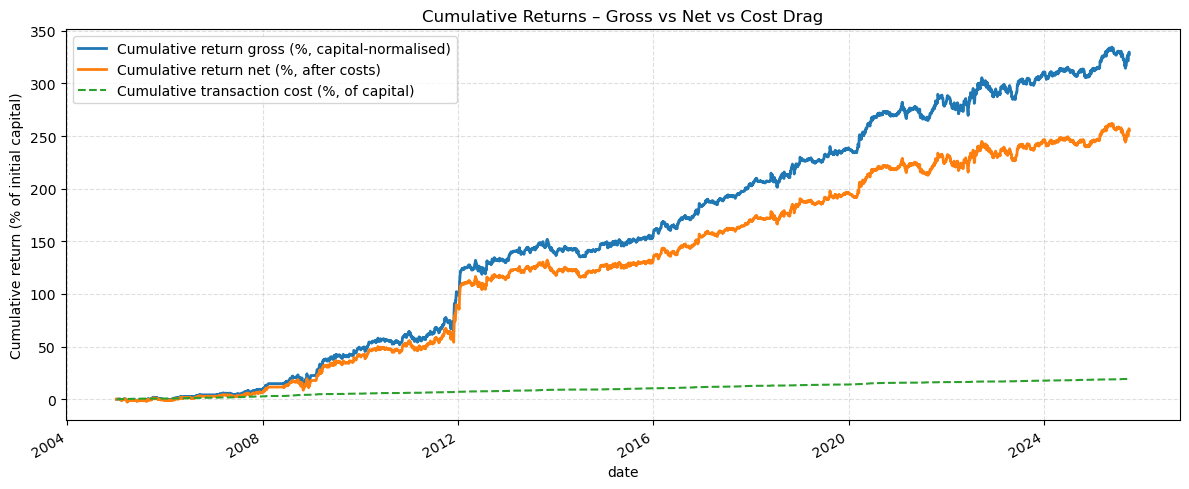

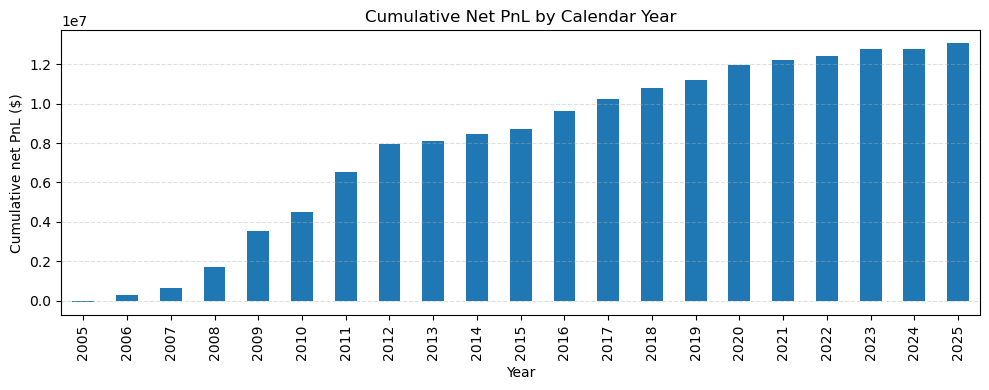

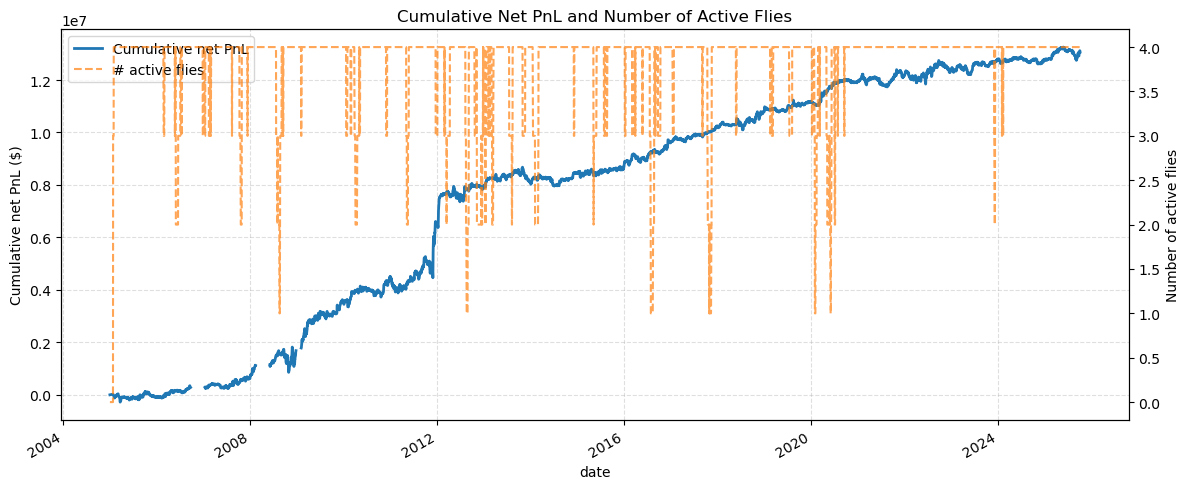

In [114]:
## Plotting: 

CAPITAL_TOTAL = MAX_FLY_POSITIONS * DV01_LIMIT_FLY * CAPITAL_PER_DV01

cum_ret_gross = portfolio_bt_cost["cum_ret_capital_gross"]
cum_ret_net = portfolio_bt_cost["cum_ret_capital_net"]
cum_cost_ret = portfolio_bt_cost["trade_cost"].cumsum() / CAPITAL_TOTAL

fig, ax = plt.subplots(figsize=(12, 5))
(cum_ret_gross * 100).plot(ax=ax, linewidth=2, label="Cumulative return gross (%, capital-normalised)")
(cum_ret_net * 100).plot(ax=ax, linewidth=2, label="Cumulative return net (%, after costs)")
(cum_cost_ret * 100).plot(ax=ax, linewidth=1.5, linestyle="--", label="Cumulative transaction cost (%, of capital)")
ax.set_title("Cumulative Returns – Gross vs Net vs Cost Drag")
ax.set_ylabel("Cumulative return (% of initial capital)")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()

pnl_yearly = portfolio_bt_cost["portfolio_daily_pnl_net"].groupby(portfolio_bt_cost.index.year).sum()
pnl_yearly_cum = pnl_yearly.cumsum()

fig, ax = plt.subplots(figsize=(10, 4))
pnl_yearly_cum.plot(kind="bar", ax=ax)
ax.set_title("Cumulative Net PnL by Calendar Year")
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative net PnL ($)")
ax.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

cum_pnl_net = portfolio_bt_cost["portfolio_daily_pnl_net"].cumsum()

fig, ax1 = plt.subplots(figsize=(12, 5))
cum_pnl_net.plot(ax=ax1, linewidth=2, label="Cumulative net PnL")
ax1.set_title("Cumulative Net PnL and Number of Active Flies")
ax1.set_ylabel("Cumulative net PnL ($)")
ax1.grid(True, linestyle="--", alpha=0.4)

ax2 = ax1.twinx()
portfolio_bt_cost["num_active_positions"].plot(
    ax=ax2,
    linestyle="--",
    alpha=0.7,
    color="tab:orange",
    label="# active flies",
)
ax2.set_ylabel("Number of active flies")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()


# Implementing the asset class proxy comps from Yahoo - and other benchmarks

/var/folders/tl/hb3sh0p16wb8f6cdsnkjq_wm0000gn/T/ipykernel_17260/2683339523.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yahoo_data = yf.download(
[*********************100%***********************]  9 of 9 completed


Correlation of strategy daily returns vs major asset-class proxies:


US IG Credit (LQD)           0.0395
US HY Credit (HYG)           0.0315
FI RV proxy (TLT–IEF)        0.0241
US Long Treasuries (TLT)     0.0212
US 7–10Y Treasuries (IEF)    0.0140
US Equities (SPY)            0.0108
US REITs (VNQ)               0.0092
Broad Commodities (DBC)      0.0083
EM Equities (EEM)           -0.0026
Gold (GLD)                  -0.0104
Name: Strategy, dtype: float64

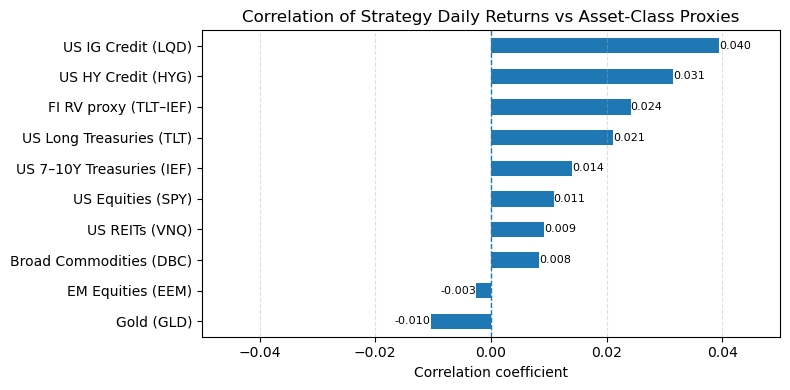

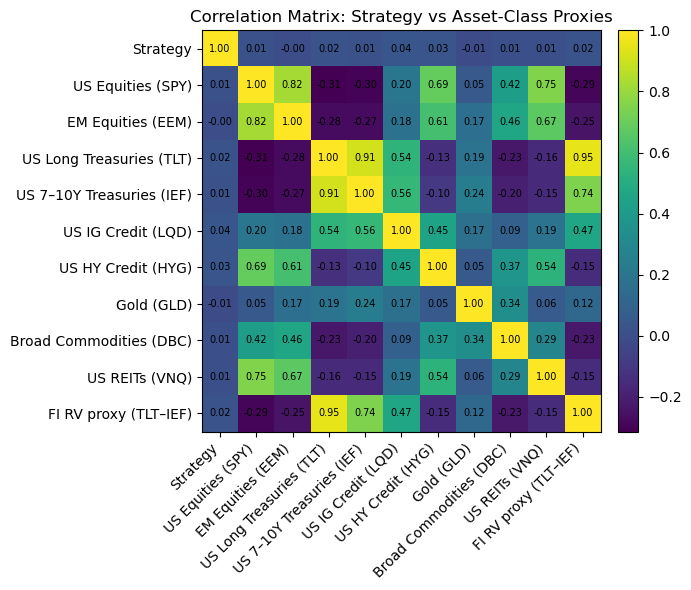

Available return series in 'combined':
['Strategy', 'US Equities (SPY)', 'EM Equities (EEM)', 'US Long Treasuries (TLT)', 'US 7–10Y Treasuries (IEF)', 'US IG Credit (LQD)', 'US HY Credit (HYG)', 'Gold (GLD)', 'Broad Commodities (DBC)', 'US REITs (VNQ)']


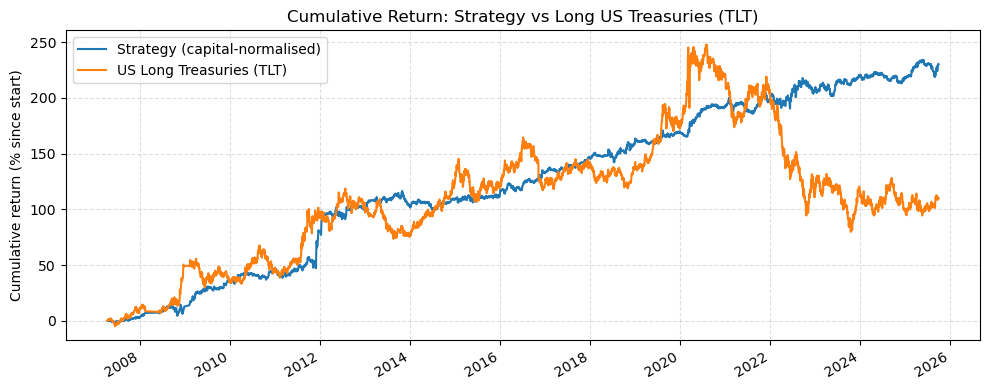

In [116]:
strategy_ret = portfolio_bt_cost["ret_capital_net"].dropna().rename("Strategy")

start = strategy_ret.index.min().strftime("%Y-%m-%d")
end = strategy_ret.index.max().strftime("%Y-%m-%d")

yahoo_tickers = {
    "SPY": "US Equities (SPY)",
    "EEM": "EM Equities (EEM)",
    "TLT": "US Long Treasuries (TLT)",
    "IEF": "US 7–10Y Treasuries (IEF)",
    "LQD": "US IG Credit (LQD)",
    "HYG": "US HY Credit (HYG)",
    "GLD": "Gold (GLD)",
    "DBC": "Broad Commodities (DBC)",
    "VNQ": "US REITs (VNQ)",
}

print(f"Downloading Yahoo data from {start} to {end} ...")
yahoo_data = yf.download(
    list(yahoo_tickers.keys()),
    start=start,
    end=end,
    group_by="ticker",
)

def extract_prices_from_yahoo(raw, tickers):
    import pandas as pd

    if isinstance(raw.columns, pd.MultiIndex):
        price_df = {}
        for tic in tickers:
            if tic not in raw.columns.get_level_values(0):
                continue
            sub = raw[tic]
            if "Adj Close" in sub.columns:
                price_df[tic] = sub["Adj Close"]
            elif "Close" in sub.columns:
                price_df[tic] = sub["Close"]
        return pd.DataFrame(price_df)

    cols = list(raw.columns)
    if "Adj Close" in cols:
        return raw[["Adj Close"]].rename(columns={"Adj Close": tickers[0]})
    elif "Close" in cols:
        return raw[["Close"]].rename(columns={"Close": tickers[0]})
    else:
        raise ValueError(f"Could not find 'Adj Close' or 'Close' in Yahoo data columns: {cols}")

prices = extract_prices_from_yahoo(yahoo_data, list(yahoo_tickers.keys()))
asset_ret = prices.pct_change()
combined = pd.concat([strategy_ret, asset_ret], axis=1).dropna(how="any")

rename_map = {tic: name for tic, name in yahoo_tickers.items() if tic in combined.columns}
combined = combined.rename(columns=rename_map)

fi_proxy = None
if ("US Long Treasuries (TLT)" in combined.columns) and ("US 7–10Y Treasuries (IEF)" in combined.columns):
    fi_proxy = (
        combined["US Long Treasuries (TLT)"] -
        combined["US 7–10Y Treasuries (IEF)"]
    ).rename("FI RV proxy (TLT–IEF)")
    combined_corr = pd.concat([combined, fi_proxy], axis=1)
else:
    combined_corr = combined
    print("Warning: could not build FI RV proxy (TLT–IEF); one of the legs is missing.")

corr_matrix = combined_corr.corr()
strategy_corr = corr_matrix.loc["Strategy"].drop("Strategy")

print("\nCorrelation of strategy daily returns vs major asset-class proxies:")
display(strategy_corr.sort_values(ascending=False).round(4))

corr_sorted = strategy_corr.sort_values()

fig, ax = plt.subplots(figsize=(8, 4))
corr_sorted.plot(kind="barh", ax=ax)

ax.axvline(0.0, linestyle="--", linewidth=1)
ax.set_title("Correlation of Strategy Daily Returns vs Asset-Class Proxies")
ax.set_xlabel("Correlation coefficient")

xmin = min(-0.05, corr_sorted.min() - 0.01)
xmax = max(0.05, corr_sorted.max() + 0.01)
ax.set_xlim(xmin, xmax)

for i, (label, value) in enumerate(corr_sorted.items()):
    ax.text(
        value,
        i,
        f"{value:.3f}",
        va="center",
        ha="left" if value >= 0 else "right",
        fontsize=8,
    )

ax.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

labels = corr_matrix.columns.tolist()

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(corr_matrix.values, aspect="auto")

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)

ax.set_title("Correlation Matrix: Strategy vs Asset-Class Proxies")

for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        val = corr_matrix.iloc[i, j]
        ax.text(
            j, i,
            f"{val:.2f}",
            ha="center",
            va="center",
            fontsize=7,
        )

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

bench_label = "US Long Treasuries (TLT)"

available_cols = list(combined.columns)
print("Available return series in 'combined':")
print(available_cols)

if bench_label in combined.columns:
    pair = combined[["Strategy", bench_label]].dropna()
    pair.columns = ["Strategy", bench_label]

    strategy_eq = (1.0 + pair["Strategy"]).cumprod()
    bench_eq = (1.0 + pair[bench_label]).cumprod()

    fig, ax = plt.subplots(figsize=(10, 4))
    (strategy_eq - 1.0).mul(100).plot(ax=ax, label="Strategy (capital-normalised)")
    (bench_eq - 1.0).mul(100).plot(ax=ax, label=bench_label)

    ax.set_title("Cumulative Return: Strategy vs Long US Treasuries (TLT)")
    ax.set_ylabel("Cumulative return (% since start)")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Cannot plot benchmark: '{bench_label}' not found in combined.columns.")
    print("Columns available:", available_cols)
